In [ ]:
from os import listdir
from os.path import isdir
from numpy import asarray
import numpy as np
import cv2 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

In [ ]:
# inside Keras
MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}

## Pre -Processing functions

In [ ]:
 def image_processing(img):
    # Convert image to grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Modify image contrast
    R, G, B = cv2.split(img)
    R = cv2.equalizeHist(R.astype(np.uint8))
    G = cv2.equalizeHist(G.astype(np.uint8))
    B = cv2.equalizeHist(B.astype(np.uint8))
    
    img = cv2.merge((R, G, R))
    # Remove noising
    img = cv2.medianBlur(img, 3)
    return img 

In [ ]:
# image resize
#resnet50 , VGG16, VGG19 224
#inception , xception 299

def image_resize(path, input_size=224):
    img = tf.keras.preprocessing.image.load_img(path, grayscale=False, color_mode='rgb', target_size=(input_size, input_size),interpolation='nearest')
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img = image_processing(img_arr)
    img = np.array(img_arr)
    #print(img_arr.shape)
    return img

In [ ]:
#0=exchange Paper, 1=looking at friend, 2=Talking Friend, 3=Use Cheat Sheet, 4=No Cheat
labels = ("exchange Paper" , "looking at friend" , "Talking Friend", "Use Cheat Sheet", "No Cheat")
len(labels)

5

In [ ]:
# load datasets


def load_datasets(dataset_directory,input_size=224):
    files = list()
    labels = list()
    a = 0
    for folder in listdir(dataset_directory):
        #get path
        path_folder = dataset_directory + folder + '/'
        #load faces in the path_folder
        if not isdir(path_folder):
            continue
            
        if folder == "exchange Paper":
            a = 0
        elif folder == "looking at friend":
            a = 1
        elif folder == "Talking Friend":
            a = 2
        elif folder == "Use Cheat Sheet":
            a = 3
        elif folder == "No Cheat":
            a = 4
        
        for filename in listdir(path_folder):
            #img = cv2.imread(path_folder+filename)
            img = image_resize(path_folder+filename,input_size)
            files.append(img)
            labels.append(a)
            #for key, val in labels.items():
                #if val is folder:
                    #labels.append(key)
        
        print(">loaded {} examples for class: {}" .format(len(files), folder))
        
    return asarray(files), asarray(labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/datasets/cheating.zip" -d "/content/drive/My Drive/datasets"

## Load dataset with specify size of model

## Load datasets: train and test sets

In [ ]:
input_shape = 299 # specify input size according of model

In [ ]:
# load train set

print('Load train set:')
x_train, y_train = load_datasets("/content/drive/My Drive/datasets/cheating/train/", input_size=input_shape)

Load train set:
>loaded 24 examples for class: exchange Paper
>loaded 91 examples for class: looking at friend
>loaded 106 examples for class: Talking Friend
>loaded 131 examples for class: Use Cheat Sheet
>loaded 202 examples for class: No Cheat


In [ ]:
print(x_train.shape, y_train.shape)

(202, 299, 299, 3) (202,)


In [ ]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

In [ ]:
# load test set

print('Load test set:')
x_test, y_test = load_datasets("/content/drive/My Drive/datasets/cheating/test/", input_size=input_shape)

Load test set:
>loaded 9 examples for class: exchange Paper
>loaded 38 examples for class: looking at friend
>loaded 72 examples for class: No Cheat
>loaded 78 examples for class: Talking Friend
>loaded 92 examples for class: Use Cheat Sheet


In [ ]:
from sklearn.model_selection import train_test_split

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.8, test_size=0.2, random_state=101)

In [ ]:
print(x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(73, 299, 299, 3) (73,) (19, 299, 299, 3) (19,)


In [ ]:
input_model = MODELS["xception"]

In [ ]:
input_model

<function tensorflow.python.keras.applications.xception.Xception>

## Create Model

In [ ]:
def Model(base_model = input_model, input_size = input_shape):
    baseModel = base_model(weights="imagenet", include_top=False,input_tensor=tf.keras.layers.Input(shape=(input_size, input_size, 3)))

    _model = baseModel.output
    _model = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(_model)
    _model = tf.keras.layers.Flatten(name="flatten")(_model)
    _model = tf.keras.layers.Dense(512, activation="relu")(_model)
    _model = tf.keras.layers.Dropout(0.5)(_model)
    _model = tf.keras.layers.Dense(len(labels), activation="softmax")(_model)
   
    model = tf.keras.models.Model(inputs=baseModel.input, outputs=_model)

    for layer in baseModel.layers:
        layer.trainable = True
    
    return model, input_size

In [ ]:
model, input_size = Model()

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# set batch size and epoch
epochs = 1000
batch_size = 16

In [ ]:
x_train = x_train.reshape(x_train.shape[0], input_size, input_size, 3)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], input_size, input_size, 3)
x_test = x_test.astype('float32')
x_val = x_val.reshape(x_val.shape[0], input_size, input_size, 3)
x_val = x_val.astype('float32')

# apply onhot on labels
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

train_size = len(x_train)
val_size = len(x_val)

print(y_test.shape)
print(y_test)

(73, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = generator.flow(x_train, y_train, batch_size=batch_size)
val_generator = generator.flow(x_val, y_val, batch_size=batch_size)

model.compile(loss='categorical_crossentropy'
, optimizer=tf.keras.optimizers.Adam()
, metrics=['accuracy']
)

#if input_model == MODELS["vgg16"] or input_model == MODELS["vgg19"]:
#  model.load_weights('/content/drive/My Drive/datasets/weights.hdf5')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
histories = model.fit(train_generator,validation_data= val_generator, steps_per_epoch=train_size//batch_size, epochs=epochs, validation_steps = val_size//batch_size)

Epoch 1/1000
12/12 [==============================] - 9s 738ms/step - loss: 0.0082 - accuracy: 0.9946 - val_loss: 6.2243 - val_accuracy: 0.3750
Epoch 2/1000


KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/My Drive/models/H_A_R_model_restnet50.hdf5')

In [ ]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.006962932180613279
Train accuracy: 99.50494766235352
Test loss: 2.68229079246521
Test accuracy: 53.4246563911438


In [ ]:
import cv2

test_img = image_resize("/content/drive/My Drive/datasets/teencheating.jpg", input_size=224)
print(test_img.shape)
test_img= np.expand_dims(test_img, axis=0)
test_img = test_img.astype('float32')
test_img /= 255
print(test_img.shape)
pred = model.predict(test_img)
print(pred)
print(max(max(pred)))

(224, 224, 3)
(1, 224, 224, 3)
[[1.0000000e+00 8.1242994e-31 3.4476805e-37 1.0388930e-28 5.6425778e-26]]
1.0


In [ ]:
print(y_test[:3])

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [ ]:
def pred_activty(path, i = 0, input_size = 224):

  test_img = image_resize(path, input_size=input_size)
  print(test_img.shape)
  test_img= np.expand_dims(test_img, axis=0)
  test_img = test_img.astype('float32')
  test_img /= 255
  print(test_img.shape)
  pred = model.predict(test_img)

  pred_res = pred[0]
  pred_max = max(pred_res)

  # index
  indice_max = -1
  for i in range(len(pred_res)):
    if pred_res[i] == pred_max:
      indice_max = i
      print(indice_max)
  
  import cv2
  import matplotlib.pyplot as plt
  frame = cv2.imread(path)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # draw the predicted activity on the frame
  cv2.rectangle(frame, (0, 0), (300, 40), (0, 0, 0), -1)
  cv2.putText(frame, labels[indice_max], (10, 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
  plt.imshow(frame)
  plt.savefig("/content/drive/My Drive/reports/result_teencheating" + str(i) +".jpg")



(224, 224, 3)
(1, 224, 224, 3)
0


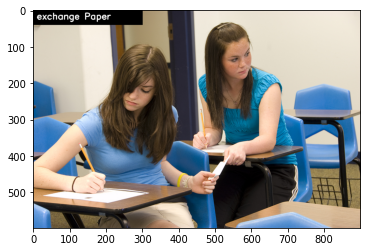

In [ ]:
pred_activty("/content/drive/My Drive/datasets/teencheating.jpg", 0, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


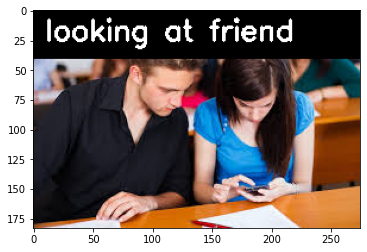

In [ ]:
pred_activty("/content/drive/My Drive/datasets/images.jpeg",1, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


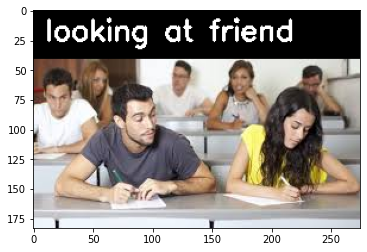

In [ ]:
pred_activty("/content/drive/My Drive/datasets/images_2.jpeg",2, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


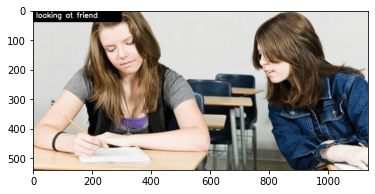

In [ ]:
pred_activty("/content/drive/My Drive/datasets/images_3.jpg",3, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


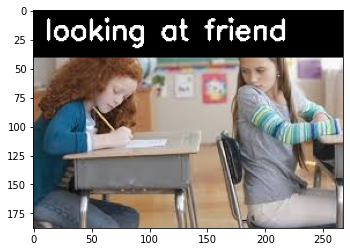

In [ ]:
pred_activty("/content/drive/My Drive/datasets/images_1.jpeg",4, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


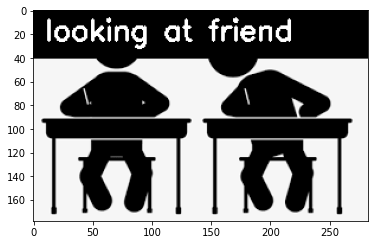

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test1.png",5, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
3


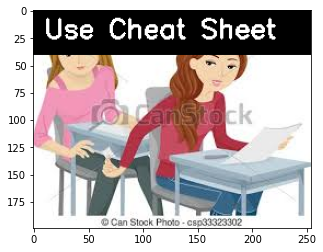

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test2.jpeg",6, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
1


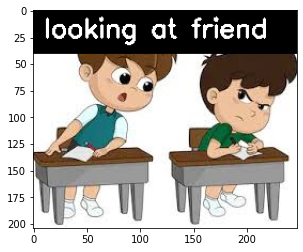

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test3.jpeg",7, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
2


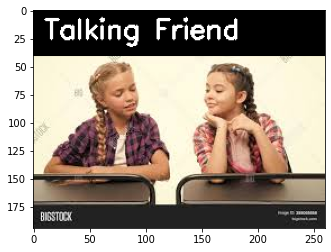

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test4.jpeg",8, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
3


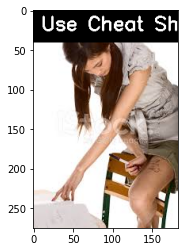

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test5.jpeg",9, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
4


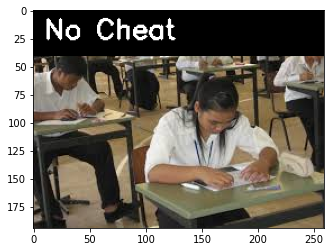

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test6.jpeg",10, input_size=224)

(224, 224, 3)
(1, 224, 224, 3)
4


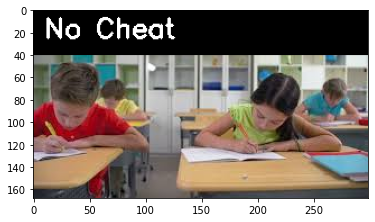

In [ ]:
pred_activty("/content/drive/My Drive/datasets/test7.jpeg",10, input_size=224)

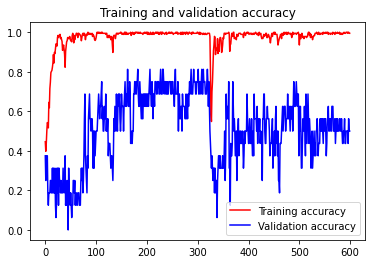

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = histories.history['accuracy']
val_acc = histories.history['val_accuracy']
loss = histories.history['loss']
val_loss = histories.history['val_loss']
#prec = histories.history['precision']
#val_prec = histories.history['val_precision']
#recall = histories.history['recall']
#val_recall = histories.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/cheattrain_val_acc_100_epochs_batch_64.png")

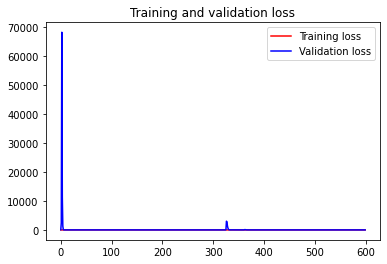

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/cheattrain_val_loss_100_epochs_batch_64.png")

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred

array([[5.04126629e-10, 1.00000000e+00, 8.71102523e-10, 1.43353773e-08,
        4.91321817e-10],
       [2.16974809e-06, 1.22956624e-02, 5.79959655e-04, 1.00618990e-06,
        9.87121165e-01],
       [7.76717934e-05, 9.83122885e-01, 9.54456802e-04, 1.54347336e-02,
        4.10237524e-04],
       [1.86264826e-09, 9.99986887e-01, 1.30376775e-05, 1.69446750e-08,
        5.48725865e-08],
       [1.54082164e-01, 3.34342629e-01, 3.84903014e-01, 1.04191206e-01,
        2.24809423e-02],
       [5.81432550e-06, 9.96492326e-01, 2.08153785e-03, 9.92855275e-05,
        1.32113125e-03],
       [6.83680219e-06, 9.99952316e-01, 6.78471133e-06, 3.65011289e-07,
        3.37911079e-05],
       [1.18412944e-02, 9.37398314e-01, 2.94754580e-02, 1.08077861e-02,
        1.04771787e-02],
       [4.80475649e-03, 4.95664269e-01, 1.98959317e-02, 4.77013320e-01,
        2.62173242e-03],
       [4.51083411e-04, 1.45236840e-02, 3.14108212e-04, 3.96489352e-03,
        9.80746269e-01],
       [2.02994430e-04, 9.8078

In [ ]:
# build corresponding predict label
def match_pred_label(y_pred):
   pred = []

   # index
   indice_max = -1
   for pred_res in y_pred:
     pred_max = max(pred_res)
     for i in range(len(pred_res)):
       if pred_res[i] == pred_max:
         pred.append(i)
    
   return pred


In [ ]:
pred = match_pred_label(y_pred=y_pred)
print(len(pred),pred)
print(len(y_pred))

73 [1, 4, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 0, 4, 3, 3, 3, 1, 1, 1, 1, 4, 0, 4, 3, 1, 4, 4, 0, 1, 1, 0, 1, 1, 4, 2, 1, 2, 4, 4, 1, 4, 1, 4, 1, 0, 4, 1, 1, 0, 2, 4, 2, 1, 0, 1, 1, 1, 1, 2, 4, 4, 0, 1]
73


In [ ]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [ ]:
y = match_pred_label(y_test)
print(y)

[1, 4, 3, 2, 4, 1, 1, 1, 3, 1, 1, 4, 1, 1, 4, 1, 4, 3, 3, 1, 2, 1, 4, 3, 1, 2, 4, 4, 4, 1, 4, 4, 1, 3, 4, 4, 4, 4, 4, 4, 0, 1, 1, 4, 1, 4, 2, 0, 1, 1, 4, 1, 4, 1, 0, 4, 3, 1, 0, 4, 4, 3, 3, 0, 4, 2, 1, 2, 3, 4, 4, 3, 1]


In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y, pred)
print(cf_matrix)

[[ 4  0  0  0  1]
 [ 1 18  1  1  3]
 [ 0  4  1  1  0]
 [ 1  6  2  2  0]
 [ 2  9  2  0 14]]


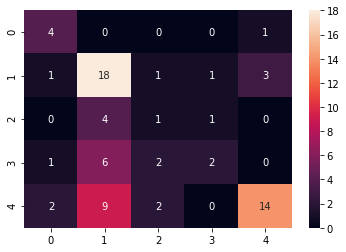

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

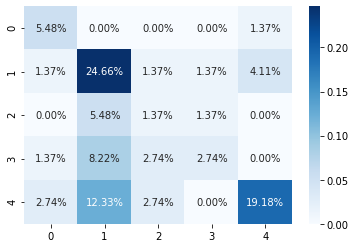

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

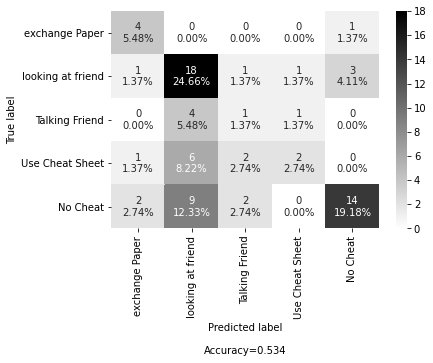

In [ ]:
_labels = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf_matrix, group_names=_labels,categories=labels, cmap='binary')

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y, pred, target_names=labels))


Classification Report

                   precision    recall  f1-score   support

   exchange Paper       0.50      0.80      0.62         5
looking at friend       0.49      0.75      0.59        24
   Talking Friend       0.17      0.17      0.17         6
  Use Cheat Sheet       0.50      0.18      0.27        11
         No Cheat       0.78      0.52      0.62        27

         accuracy                           0.53        73
        macro avg       0.49      0.48      0.45        73
     weighted avg       0.57      0.53      0.52        73

